In [0]:
import pandas as pd
data = pd.read_csv('/dbfs/FileStore/tables/AB_US_2023-1.csv')
data.head()

/root/.ipykernel/1029/command-771871627286633-135009897:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/dbfs/FileStore/tables/AB_US_2023-1.csv')


id  ...           city
0   958  ...  San Francisco
1  5858  ...  San Francisco
2  8142  ...  San Francisco
3  8339  ...  San Francisco
4  8739  ...  San Francisco

[5 rows x 18 columns]

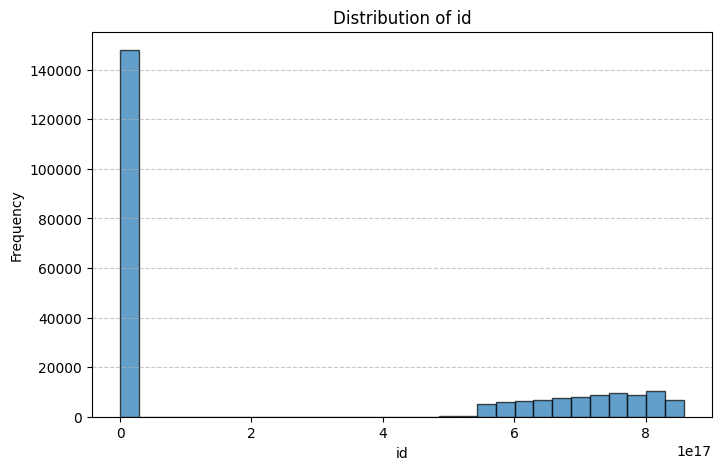

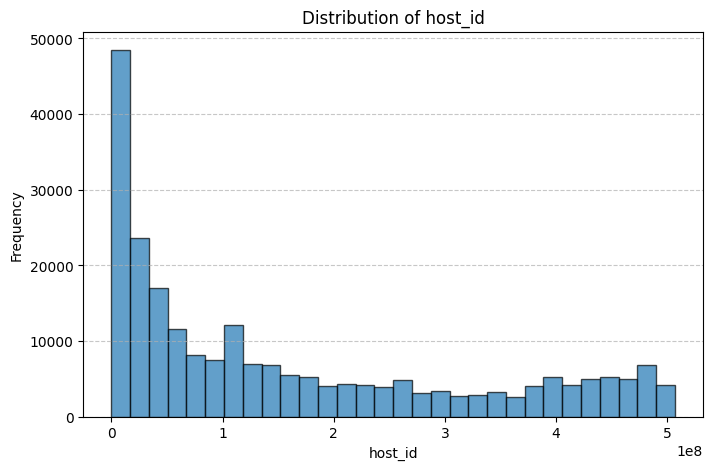

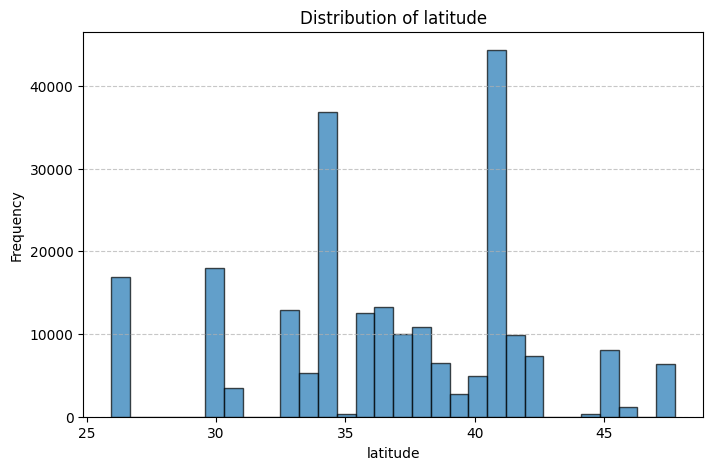

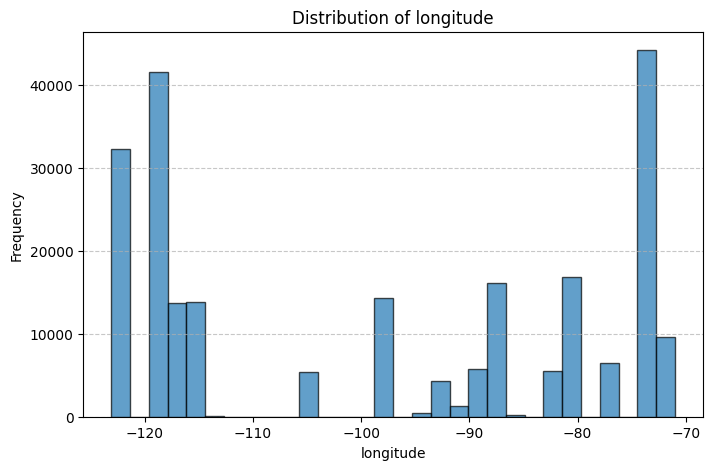

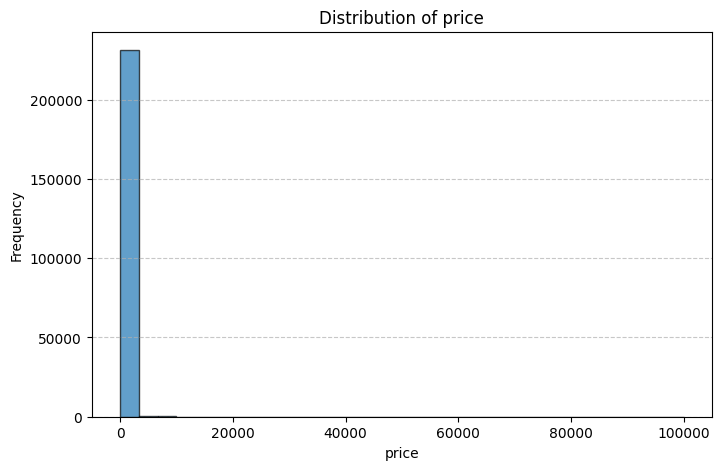

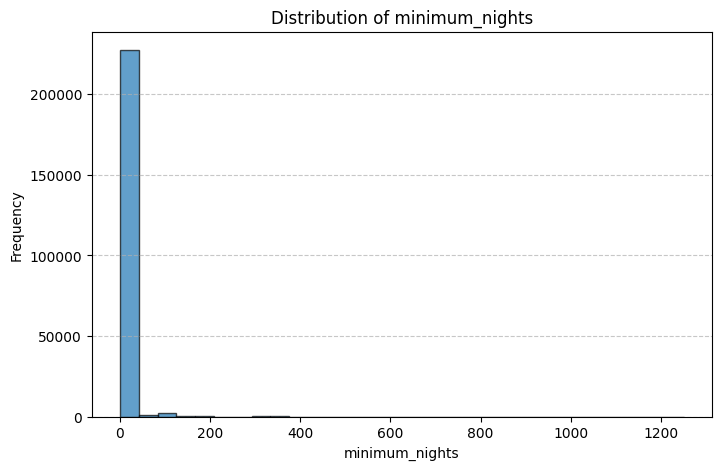

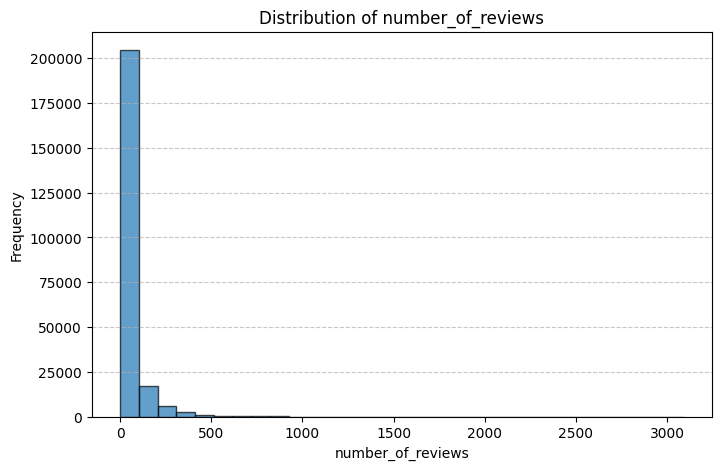

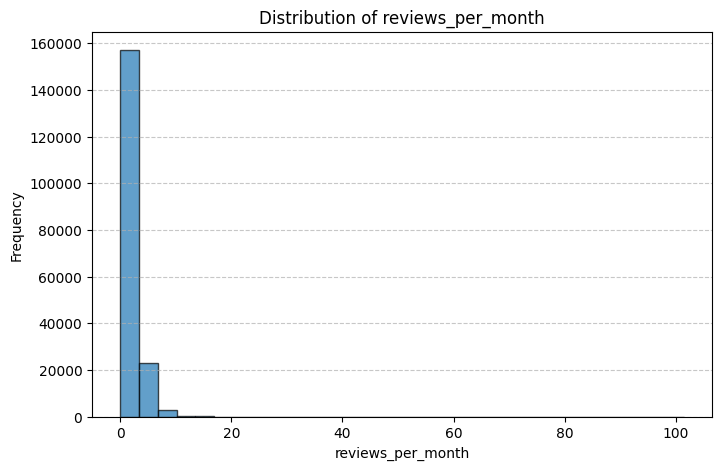

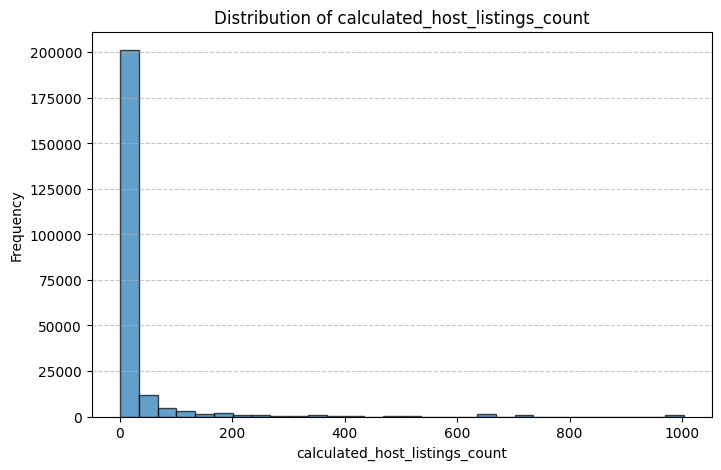

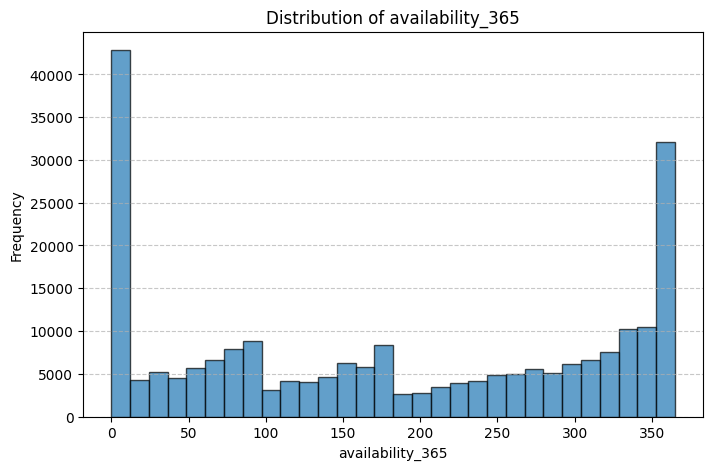

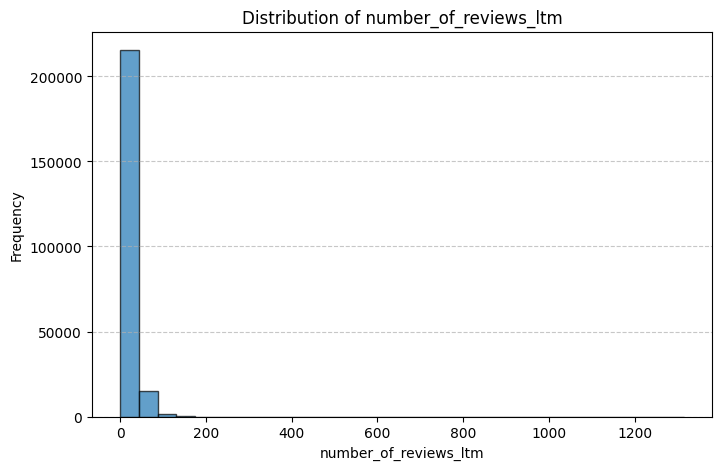

In [0]:
import matplotlib.pyplot as plt

# Step 2: Distribution of numerical variables
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns

# Plot histograms for each numerical column
for column in numerical_columns:
    plt.figure(figsize=(8, 5))
    plt.hist(data[column].dropna(), bins=30, edgecolor='k', alpha=0.7)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

In [0]:
print(data.shape)
print('\n')
print(data.isnull().sum())

(232147, 18)


id                                     0
name                                  16
host_id                                0
host_name                             13
neighbourhood_group               135647
neighbourhood                          0
latitude                               0
longitude                              0
room_type                              0
price                                  0
minimum_nights                         0
number_of_reviews                      0
last_review                        49085
reviews_per_month                  49085
calculated_host_listings_count         0
availability_365                       0
number_of_reviews_ltm                  0
city                                   0
dtype: int64


In [0]:
from datetime import datetime

data['last_review'] = pd.to_datetime(data['last_review'])
min_last_review = data['last_review'].min()
max_last_review = data['last_review'].max()
data['last_review'] = data['last_review'].fillna(min_last_review)

data['reviews_per_month'] = data['reviews_per_month'].fillna(0)

In [0]:
data['price_per_review'] = data['price'] / (data['number_of_reviews'] + 1)

# New feature: review density (number of reviews divided by availability)
data['review_density'] = data['number_of_reviews'] / (data['availability_365'] + 1)

# New feature: is_superhost (calculated_host_listings_count > threshold)
data['is_superhost'] = (data['calculated_host_listings_count'] > 5).astype(int)
data['last_review_period'] = (data['last_review'] - min_last_review).dt.days / 365
data['last_review_period'] = data['last_review_period'].astype(float)
data.head()

id  ... last_review_period
0   958  ...          12.386301
1  5858  ...           6.843836
2  8142  ...          12.071233
3  8339  ...           8.736986
4  8739  ...          12.402740

[5 rows x 22 columns]

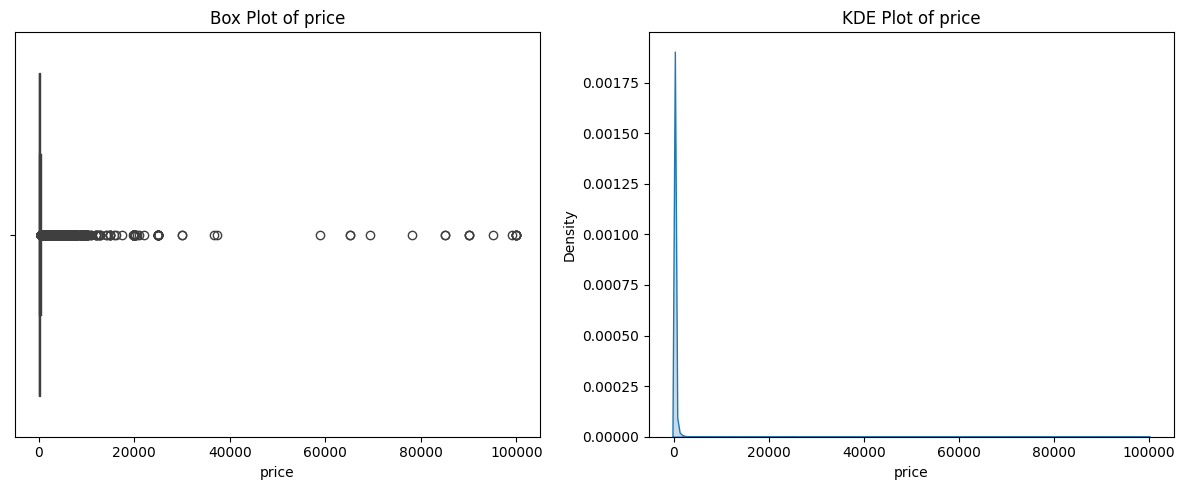

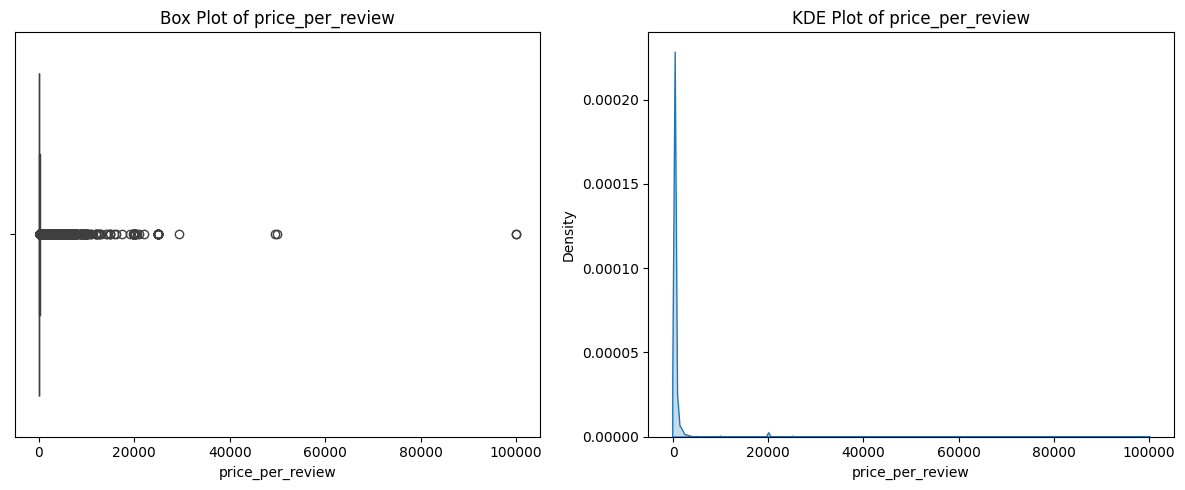

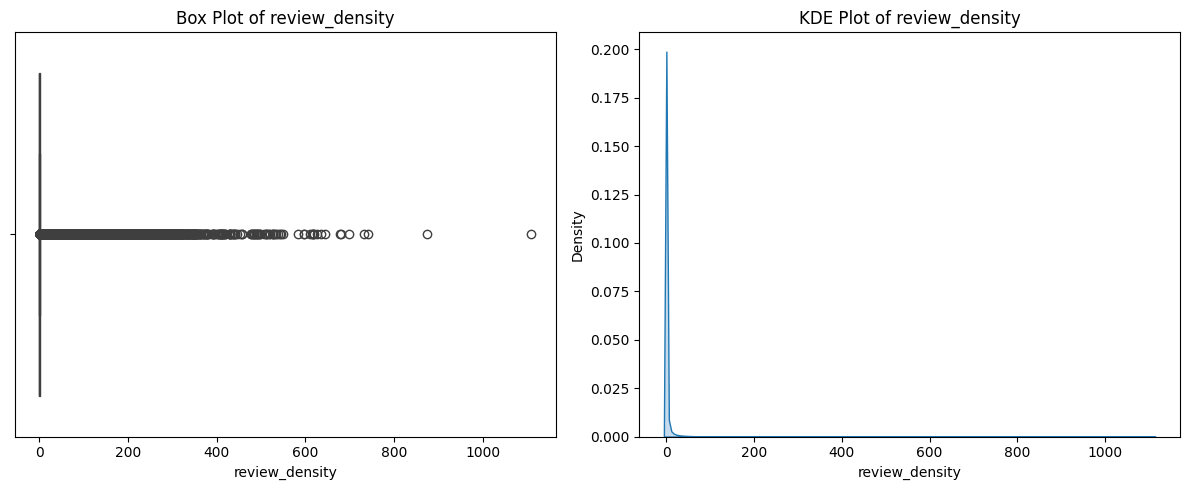

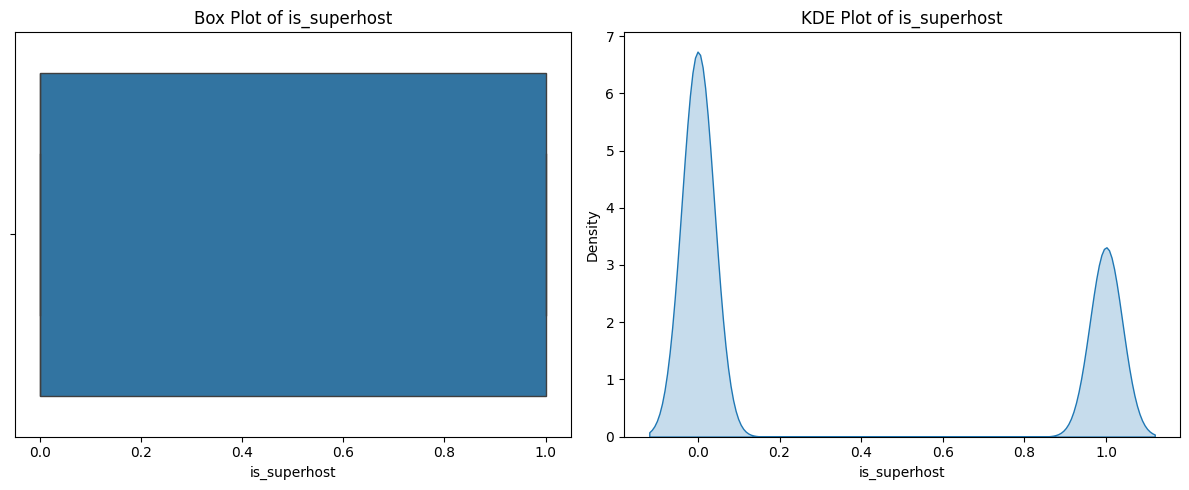

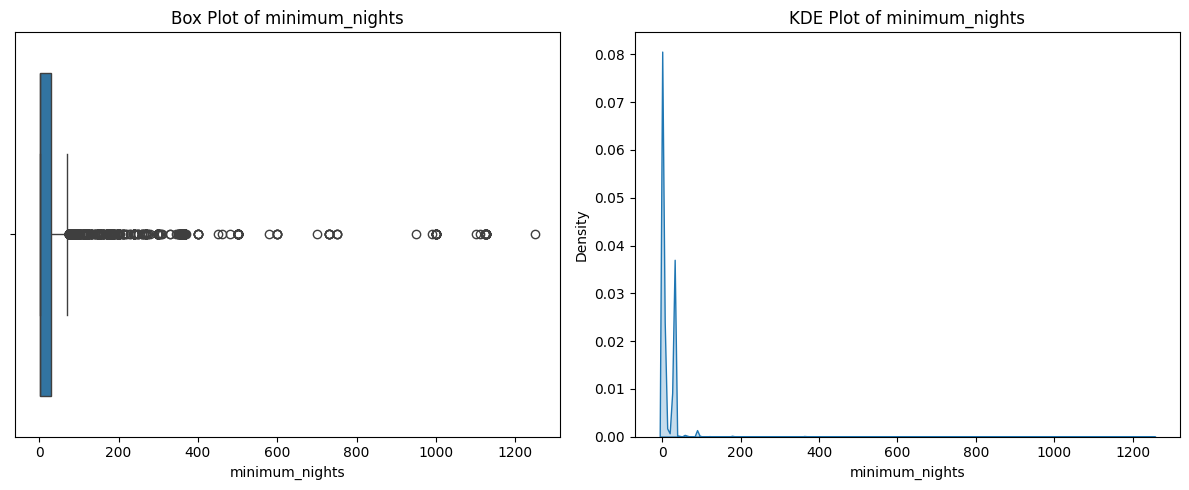

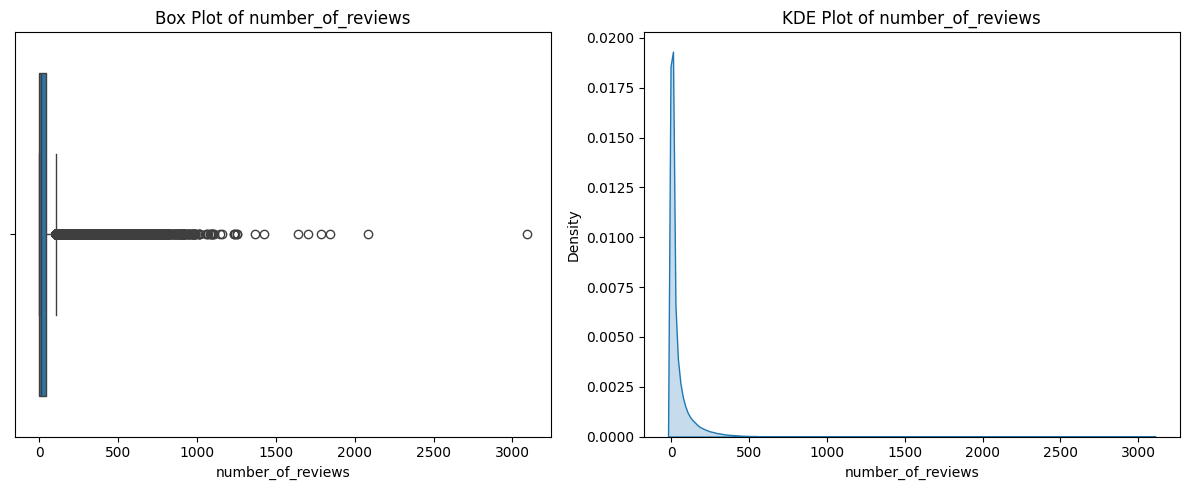

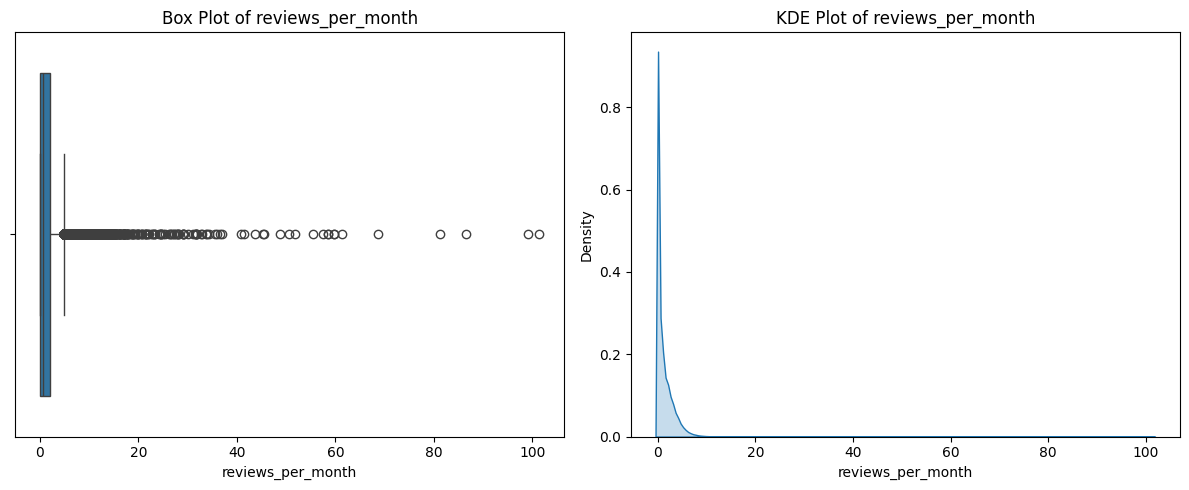

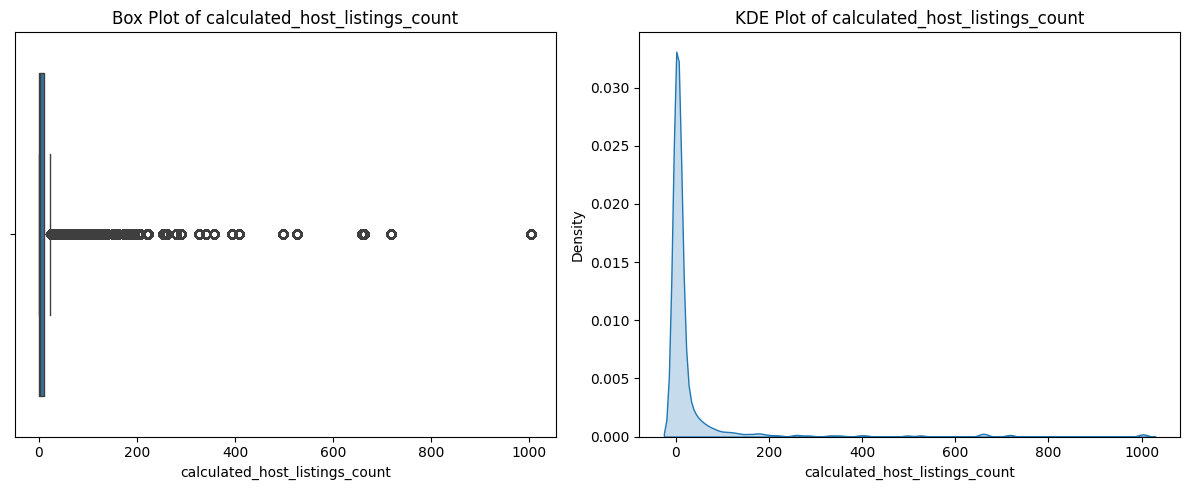

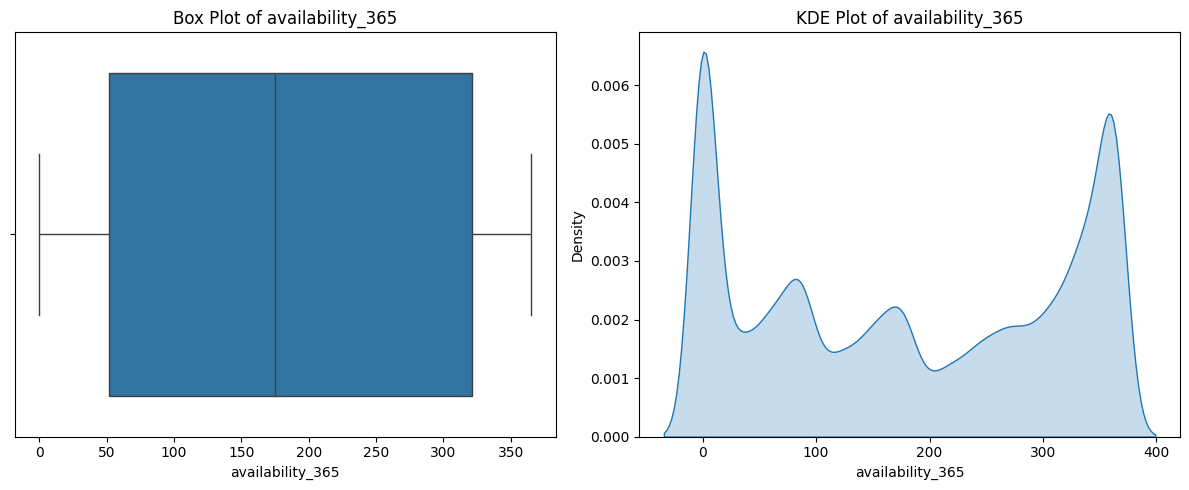

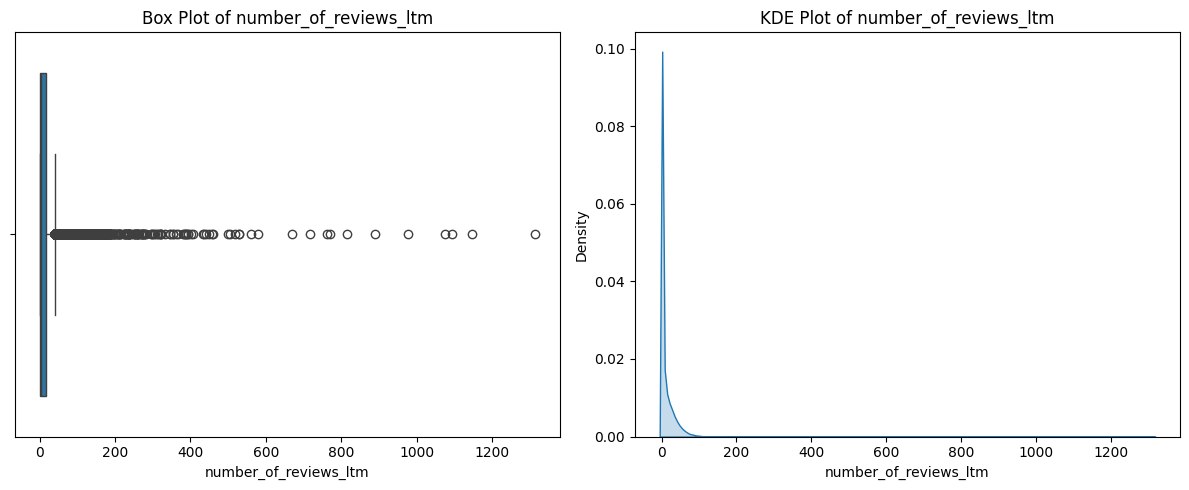

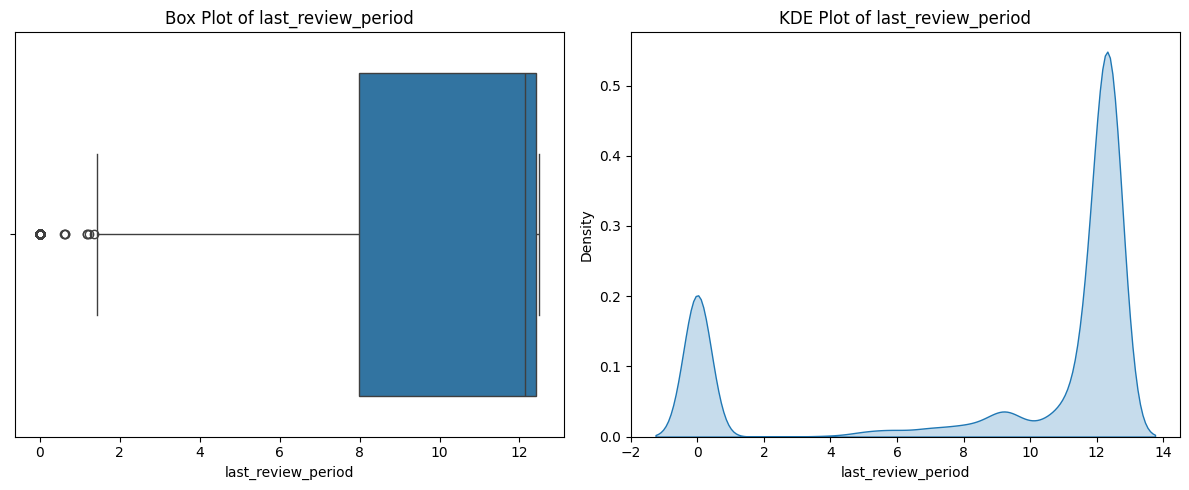

In [0]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
selected_columns = ['price','price_per_review','review_density','is_superhost', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', \
                              'availability_365', 'number_of_reviews_ltm', 'last_review_period']

for col in selected_columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Box plot
    sns.boxplot(data=data, x=col, ax=axes[0])
    axes[0].set_title(f'Box Plot of {col}')
    axes[0].set_xlabel(col)
    
    # KDE plot
    sns.kdeplot(data=data, x=col, ax=axes[1], fill=True)
    axes[1].set_title(f'KDE Plot of {col}')
    axes[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

In [0]:
import plotly.express as px


fig = px.scatter_mapbox(
    data_frame=data,                 
    lat="latitude",                  
    lon="longitude",                 
    mapbox_style="open-street-map",  
    color_discrete_sequence=["red"], 
)

fig.update_layout(
    mapbox_zoom=10,                  
    mapbox_center={"lat": data["latitude"].mean(), "lon": data["longitude"].mean()}, 
    margin={"r":0,"t":0,"l":0,"b":0} 
)


fig.show()

/root/.ipykernel/1029/command-771871627286637-1596027788:2: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



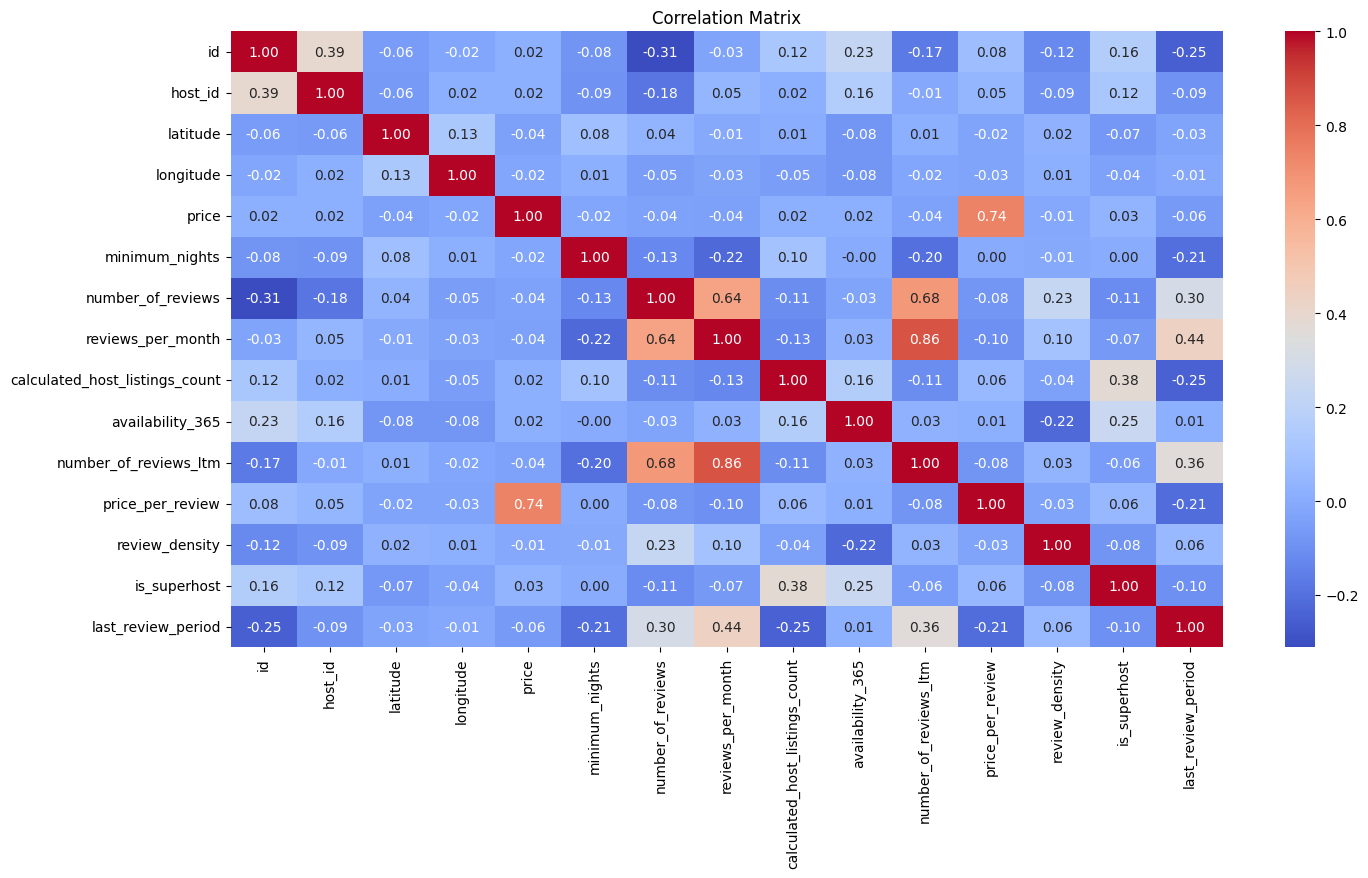

In [0]:


# Step 4: Correlation Analysis - Generate a heatmap for numerical features
correlation_matrix = data.corr()

# Plotting the heatmap
plt.figure(figsize=(16, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, mask=correlation_matrix.isnull())
plt.title('Correlation Matrix')
plt.show()


In [0]:
def determine_outlier_thresholds_iqr(dataframe, col_name, th1=0.25, th3=0.75):
    quartile1 = dataframe[col_name].quantile(th1)
    quartile3 = dataframe[col_name].quantile(th3)
    iqr = quartile3 - quartile1
    upper_limit = quartile3 + 1.5 * iqr
    lower_limit = quartile1 - 1.5 * iqr
    return lower_limit, upper_limit

def remove_outliers_iqr(dataframe, col_name, th1=0.25, th3=0.75):
    # Calculate lower and upper limitsw
    lower_limit, upper_limit = determine_outlier_thresholds_iqr(dataframe, col_name, th1, th3)

    # Filter the rows within the limits
    filtered_df = dataframe[(dataframe[col_name] >= lower_limit) & (dataframe[col_name] <= upper_limit)]
    return filtered_df

In [0]:
data = remove_outliers_iqr(data, 'price')
data = remove_outliers_iqr(data, 'minimum_nights')
data = remove_outliers_iqr(data, 'number_of_reviews')
data = remove_outliers_iqr(data, 'calculated_host_listings_count')
data = remove_outliers_iqr(data, 'reviews_per_month')
data = remove_outliers_iqr(data, 'number_of_reviews_ltm')

In [0]:
data = data[(data['price'] > 0) & (data['price'] < 5000)]
data = data[data['minimum_nights'] <= 60]
data = data[data['number_of_reviews'] <= 200]
data = data[data['reviews_per_month'] <= 6]
data = data[data['calculated_host_listings_count'] <= 50]
data = data[data['last_review_period'] > 0]

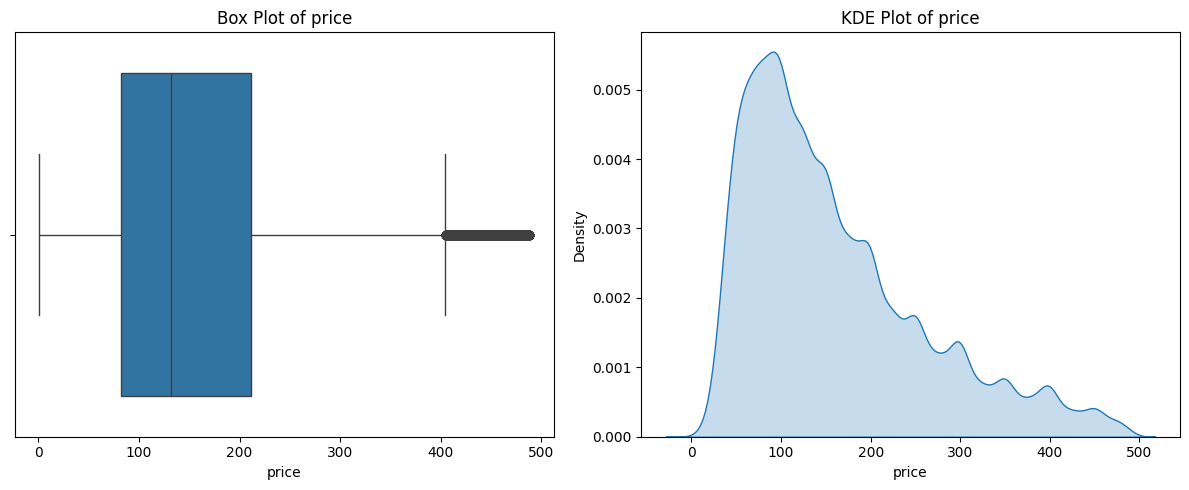

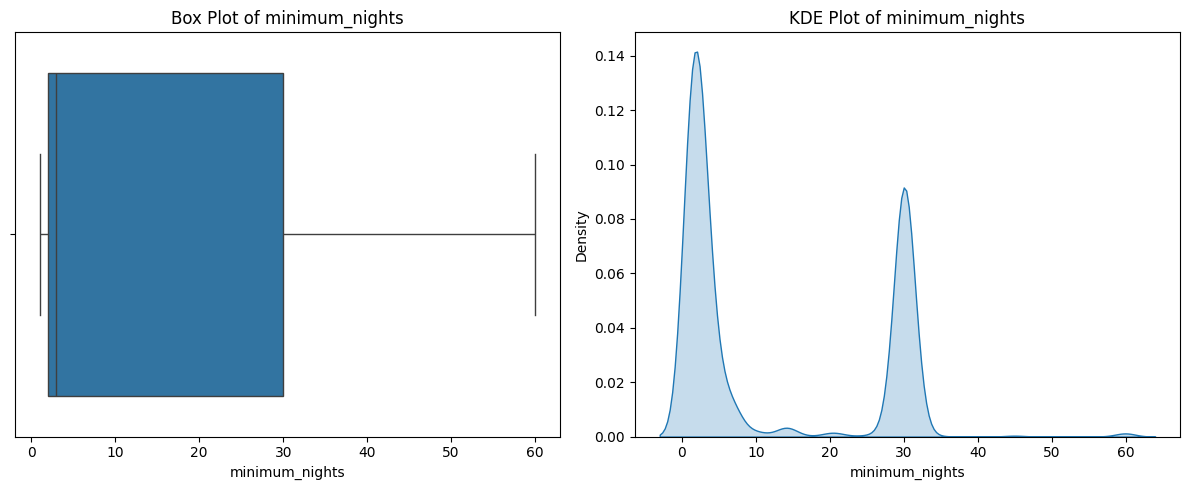

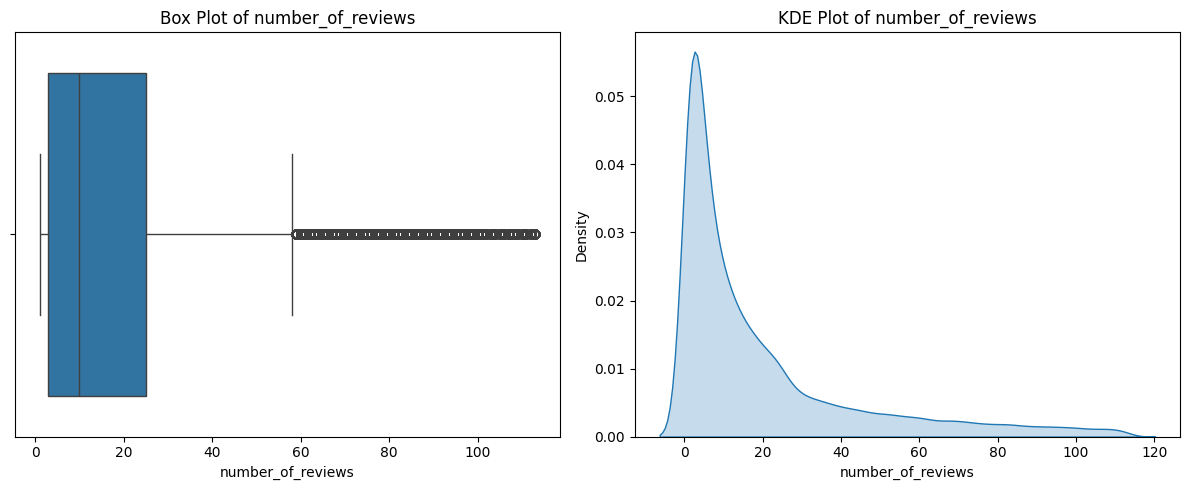

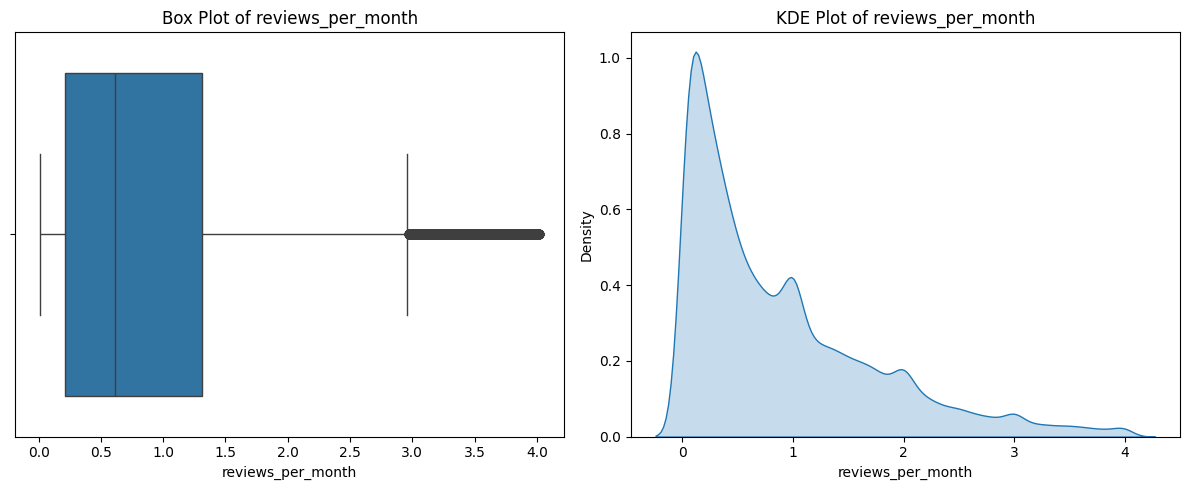

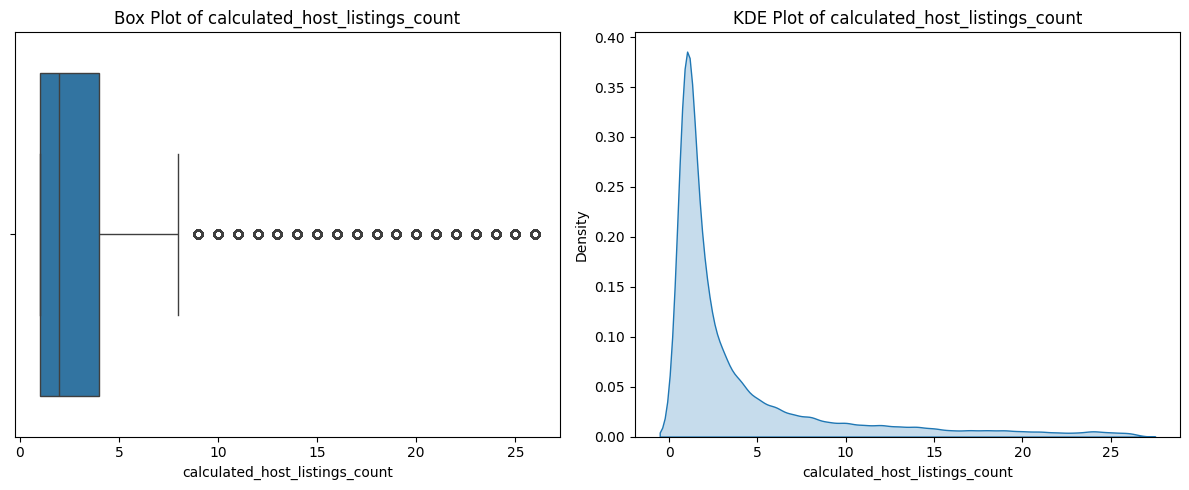

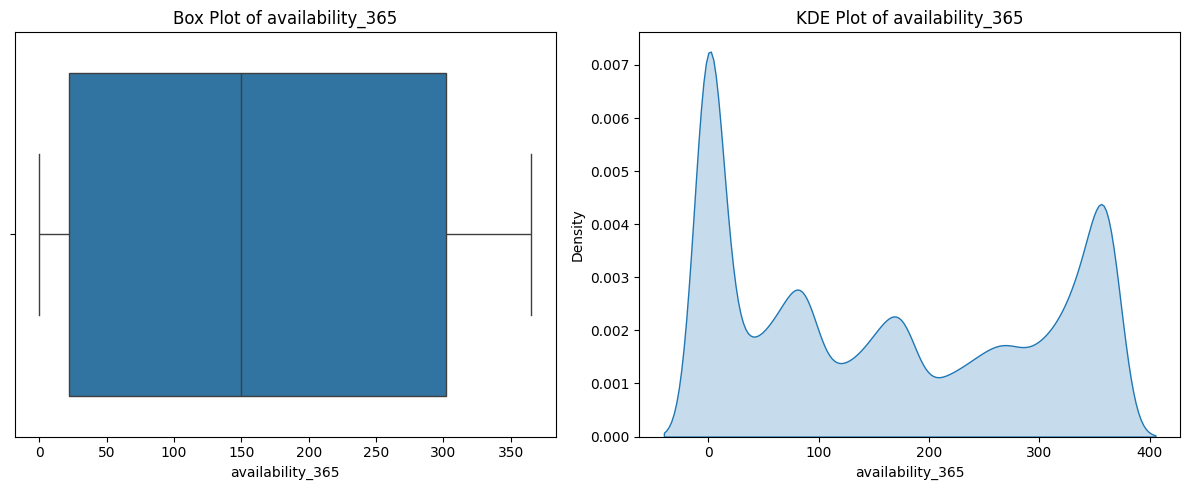

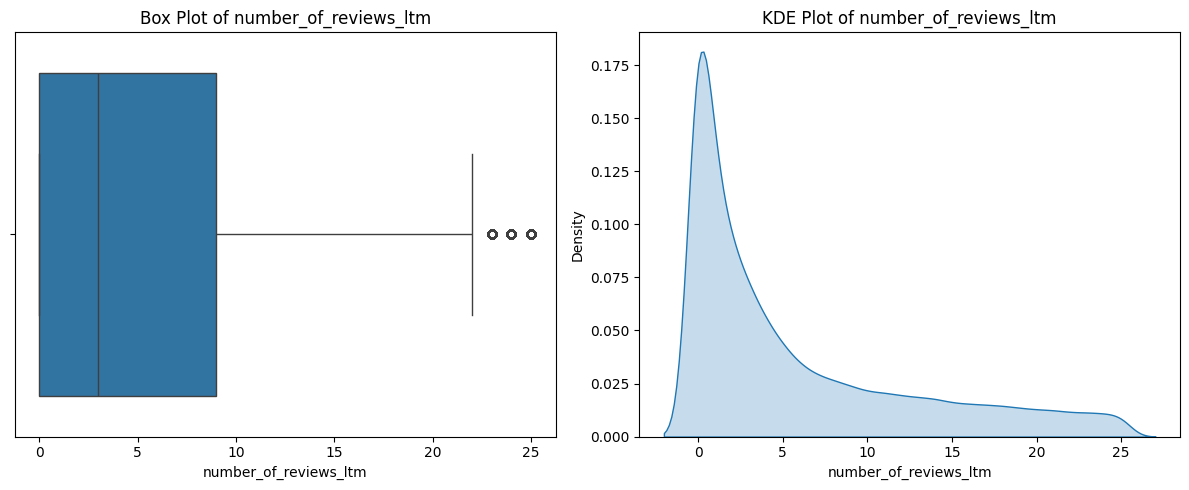

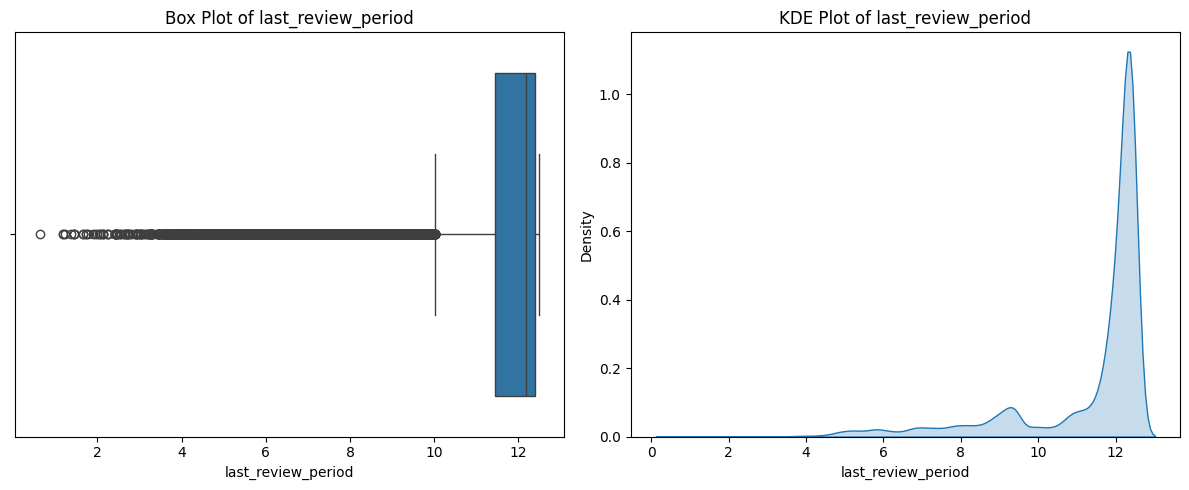

In [0]:
selected_columns = ['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', \
                              'availability_365', 'number_of_reviews_ltm', 'last_review_period']
                              
for col in selected_columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Box plot
    sns.boxplot(data=data, x=col, ax=axes[0])
    axes[0].set_title(f'Box Plot of {col}')
    axes[0].set_xlabel(col)
    
    # KDE plot
    sns.kdeplot(data=data, x=col, ax=axes[1], fill=True)
    axes[1].set_title(f'KDE Plot of {col}')
    axes[1].set_xlabel(col)

    plt.tight_layout()
    plt.show()

In [0]:
filtered_spark_df = spark.createDataFrame(data)

In [0]:
train_df, test_df = filtered_spark_df.randomSplit([0.8, 0.2], seed=42)


In [0]:
from sklearn.model_selection import train_test_split
X = data.drop(columns=['price', 'id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 
                       'neighbourhood', 'last_review'], axis=1)
y = data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_variable = X_train.select_dtypes(include=['number']).columns
cat_variable = [col for col in X_train.columns if col not in numeric_variable]

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocess_pipe = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_variable),
        ('cat', categorical_transformer, cat_variable)
    ]
)

X_train_preprocessed = preprocess_pipe.fit_transform(X_train)
X_test_preprocessed = preprocess_pipe.transform(X_test)

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

In [0]:
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', seed=42)

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.1, 0.2],
    'max_depth': [3, 5],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_preprocessed, y_train)

best_params = grid_search.best_params_
best_score = -grid_search.best_score_

y_pred = grid_search.best_estimator_.predict(X_test_preprocessed)
test_mae = mean_absolute_error(y_test, y_pred)

print("Best Parameters:", best_params)
print("Best Training MAE:", best_score)
print("Test MAE:", test_mae)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best Training MAE: 4.201373410177669
Test MAE: 4.076807339271128
